# K-Means Clustering

K-Means is an unsupervised machine learning algorithm used for clustering data into distinct groups. It aims to partition a dataset into `k` clusters, where each data point belongs to the cluster with the nearest centroid.

### How It Works:
1. **Initialization**: Select `k` initial cluster centroids randomly or using a specific heuristic.
2. **Assignment Step**: Assign each data point to the nearest cluster centroid based on a distance metric (e.g., Euclidean distance).
3. **Update Step**: Recalculate the centroids as the mean of all data points assigned to each cluster.
4. **Repeat**: Iterate the assignment and update steps until the centroids stabilize (i.e., no significant change) or a maximum number of iterations is reached.

### Limitations:
- Requires the number of clusters (`k`) to be specified in advance, although there are ways to score a classification and use the k-value with the best score, penalizing both the distance of points from the centroid and the number of clusters.
- Sensitive to outliers and initial centroid placement.
- Assumes clusters are spherical-ish and equally sized, which may not always hold true.

In [23]:
# this section adds the package path to the system path so it can be used here
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))


import mltoolbox as ml # my module

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [24]:
# Load the CSV file into a pandas DataFrame
D = pd.read_csv('../../Datasets/seeds_dataset.csv', delimiter=r'\s+', names=[
    'area',
    'perimeter', 
    'compactness', 
    'length_of_kernel', 
    'width_of_kernel', 
    'asymmetry', 
    'length_of_kernel_groove', 
    'class'])


# so our lable is the class column,
y = D['class'].to_numpy()
X = D[['area', 'asymmetry']].values


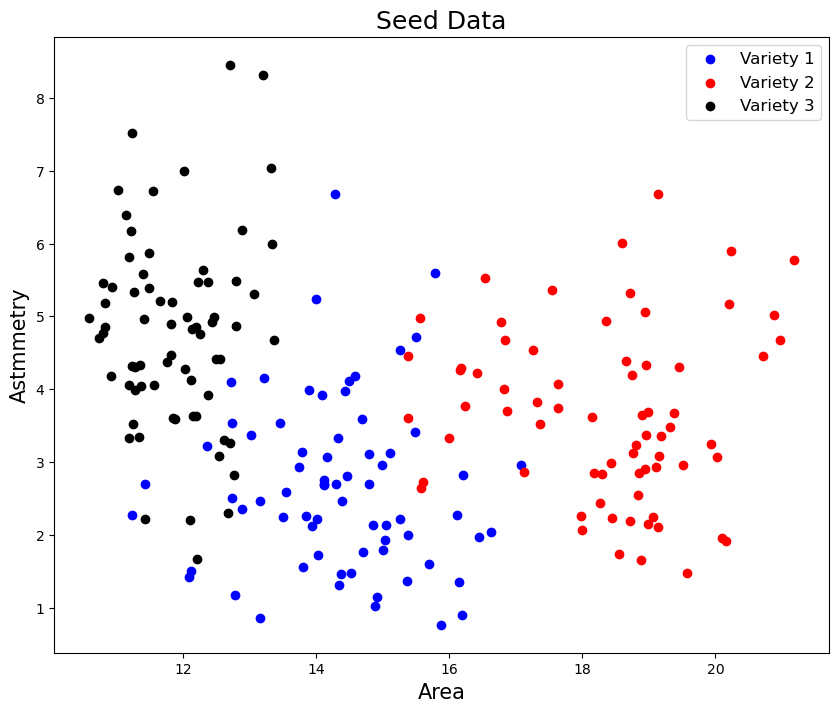

In [25]:
plt.figure(figsize=(10, 8))
plt.title("Seed Data", fontsize=18)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Variety 1')
plt.scatter(X[y == 2, 0], X[y == 2, 1], c='red', label='Variety 2')
plt.scatter(X[y == 3, 0], X[y == 3, 1], c='black', label='Variety 3')
plt.xlabel("Area", fontsize=15)
plt.ylabel("Astmmetry", fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [26]:
# this distance function we use
def distance(X, center): 
    return np.sqrt(sum((X[j] - center[j])**2 for j in range(len(X))))  

In [27]:
km = ml.kmeans(X,y,distance) # initialize an instance of the kmeans class from my module
km.make_centroids(3)
km.assign_label()


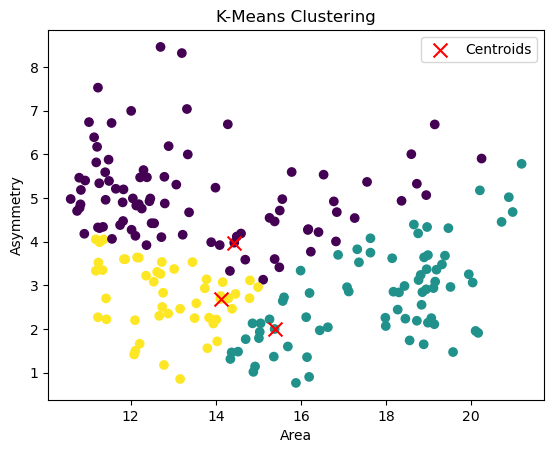

In [28]:
km.plot_spread('Area', 'Asymmetry')

Number of iterations: 9


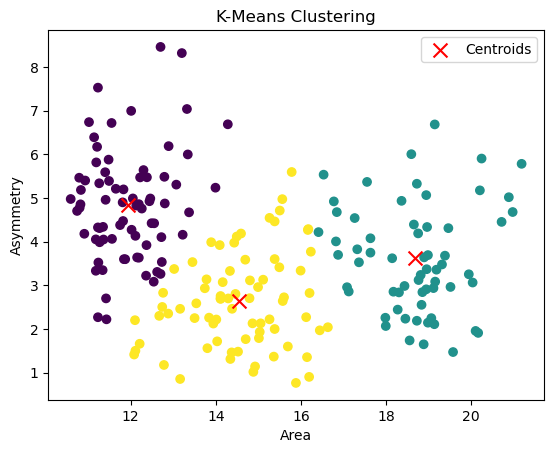

In [29]:
km.update_loop(0.001,True) #updates until the centroids dont move by more than 0.001
km.plot_spread('Area', 'Asymmetry')

# Basic K-means results

It works very well on this data set, quickly reaching what is close to the true groupings. But this is with a predetermined number of groupings given to it. To be truly unsupervised it needs to work with only the input data and decide on the number of clusters itself.

To do this, I will use the basic idea that we want densely packed data points near the center, and sparse regions near the edges. I can use a weighted version of k-nearest neighbors to determine a point's overlap with other regions. We will want to minimize the overlap from KNN. However, this will bias towards fewer groupings just because they lead to there being less perimeter to overlap on.

In [30]:
def distance(x1,x2):
      return np.sqrt(sum([(x1[i]-x2[i])**2 for i in range(len(x1))]))


def k_nearest_neighbors(point, label, X, y, k):
        # Create an empty list to store neighbors and distances
        neighbors = []

        
        for p, l in zip(X, y):
            d = distance(point, p)
            temp_data = [p, l, d]
            neighbors.append(temp_data)
  
            
        neighbors.sort(key=lambda x: x[-1])
        
        n = neighbors[:k]
        overlap = 0.0
        for nb in n:
              if nb[1]!=(label) and nb[2]!=0:
                    overlap+= 1/nb[2]
            
        return overlap

### The Group Number Decison

In the above cell there is the function that defines 'overlap' for each point. It is the sum of 1/(distance between points) for every k-nearest neighbor that is not in the same group as the point.

We take the sum of the overlaps for every point, and then to account for models with more clusters having more perimeters, we divide by:
$2*pi*sqrt(k) - pi$ 

The idea behind this is that we approximate the data as a unit circle which has its area divided up into 'k' equal circles with radius 'r'.
If the total area is conserved, then we have:

$pi*(small radius)^2*k = pi$
$r^2*k=1$
$r = 1/sqrt(k)$

Each circle has a perimeter of $2*pi*r$, so $2*pi/sqrt(k)$, and there are k circles, so there is $2*pi*sqrt(k)$ small circle perimeter, and the outer edge of the large circle is not adjacent to anything and should not count, so we subtract pi and end up with:

$2*pi*sqrt(k) - pi$ 

As our estimator for the total perimeter. We then divide the total overlap by the total perimeter to get our measure for ranking models.

The results are reasonably good, k=3 is lower than all of the nearby k-values and is a good choice for the model. However, sometimes other k-values like 2, 6 or 8 get lower scores than k=3. They change significantly between iterations, so I cannot say they are a better choice than k=3 which is consitently low.

In [31]:

for k in range(2,9):
    km.make_centroids(k)
    km.assign_label()
    km.update_loop(0.0001,True)

    ol = 0.0

    for x,lable in zip(X,km.y_hat):
        i = k_nearest_neighbors(x,lable,X,km.y_hat,8)
        ol+=i

    overlap_per_perimeter = ol/(2*np.pi*np.sqrt(k)-np.pi)
    print(f"Overlap for k={k}: {overlap_per_perimeter}")

Number of iterations: 4
Overlap for k=2: 13.713244252782587
Number of iterations: 6
Overlap for k=3: 15.615550215131531
Number of iterations: 7
Overlap for k=4: 17.57372878997116
Number of iterations: 7
Overlap for k=5: 19.713348818300524
Number of iterations: 7
Overlap for k=6: 23.232101217864365
Number of iterations: 12
Overlap for k=7: 18.704278597705787
Number of iterations: 27
Overlap for k=8: 24.943664755282303
